# Part I: Sentiment analysis using LSTM [20 points]
In this part, we perform a sentiment analysis using LSTM model. The final (improved) model should achieve a test accuracy of greater than 75%.

## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the main statistics

In [ ]:
!pip install torch torchvision -q
!pip install pandas numpy scikit-learn matplotlib seaborn -q
!pip install wordcloud torchinfo -q
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install nltk -q

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from torchinfo import summary
import spacy
from collections import Counter
from tqdm import tqdm
import time
import nltk

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import os
import pandas as pd
from tqdm import tqdm

def load_imdb_dataset(basedir):
    data = {'review': [], 'sentiment': []}
    for sentiment in ['pos', 'neg']:
        label = 1 if sentiment == 'pos' else 0
        for split in ['train', 'test']:
            path = os.path.join(basedir, split, sentiment)
            if os.path.exists(path):
                for filename in tqdm(os.listdir(path), desc=f"Loading {split}/{sentiment} reviews"):
                    if filename.endswith('.txt'):
                        file_path = os.path.join(path, filename)
                        with open(file_path, 'r', encoding='utf-8') as f:
                            data['review'].append(f.read())
                            data['sentiment'].append(label)
    return pd.DataFrame(data)


DATASET_PATH = '/kaggle/input/aclimdb/aclImdb'





In [3]:
fulldf = load_imdb_dataset(DATASET_PATH)


print("\nDataset loaded successfully.")
print(" Dataset Info:")
fulldf.info()

Loading test/neg reviews: 100%|██████████| 12500/12500 [00:56<00:00, 221.66it/s]


Dataset loaded successfully.
 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


2. Print the first 5 rows of the dataset to understand its structure

In [4]:
print(fulldf.head())

                                              review  sentiment
0  This was one of those wonderful rare moments i...          1
1  Have you seen The Graduate? It was hailed as t...          1
2  I don't watch a lot of TV, except for The Offi...          1
3  Kubrick again puts on display his stunning abi...          1
4  First of all, I liked very much the central id...          1


3. Provide a brief description of the dataset

<span style='color:green'>### I selected the Stanford IMDb movie review dataset. It is a standard collection of movie reviews for figuring out sentiment. The job is to tell if a review is positive, which is labeled 1, or negative, which is labeled 0. ###</span>

4. Display descriptive statistics

In [5]:

print(f"Number of samples: {len(fulldf)}")
print("Class distribution (%):")
print(fulldf['sentiment'].value_counts(normalize=True) * 100)

# cleaning the data
def cleantext(text):
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

fulldf['reviewcleaned'] = fulldf['review'].apply(cleantext)
fulldf['charcount'] = fulldf['reviewcleaned'].apply(len)
fulldf['wordcount'] = fulldf['reviewcleaned'].apply(lambda x: len(x.split()))

print(f"Average review length (characters): {fulldf['charcount'].mean():.2f}")
print(f"Average review length (words): {fulldf['wordcount'].mean():.2f}")

# Vocab size
fullvocab = Counter()
for text in fulldf['reviewcleaned']:
    fullvocab.update(text.split())
print(f"Total vocabulary size (unique words): {len(fullvocab)}")

Number of samples: 50000
Class distribution (%):
sentiment
1    50.0
0    50.0
Name: proportion, dtype: float64
Average review length (characters): 1249.21
Average review length (words): 229.77
Total vocabulary size (unique words): 119370


5. Handle missing values

In [6]:
print("Missing values per column:")
print(fulldf.isnull().sum())

Missing values per column:
review           0
sentiment        0
reviewcleaned    0
charcount        0
wordcount        0
dtype: int64


<span style='color:green'>### I selected the Stanford IMDb movie review dataset. It is a standard collection of movie reviews for figuring out sentiment. The job is to tell if a review is positive, which is labeled 1, or negative, which is labeled 0.
The dataset has 50,000 reviews in total, and I found no missing values. It is also perfectly split, half positive and half negative. The reviews are a sufficient size for analysis, they average about 230 words long. This gives the model plenty to learn from. ###</span>

6. Create visualizations to gain insights into the data

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


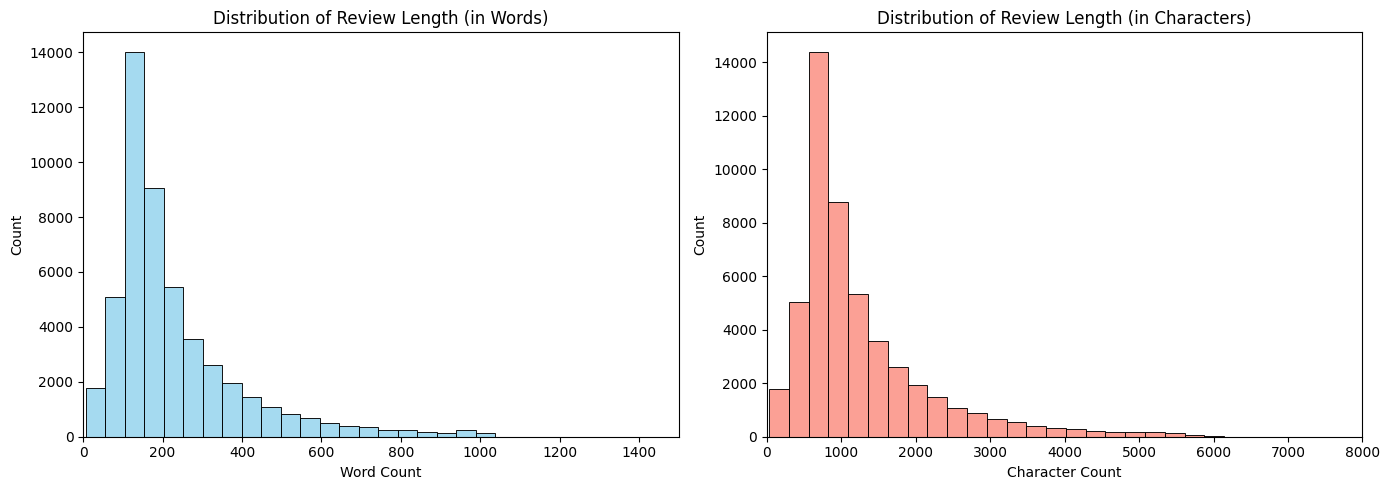

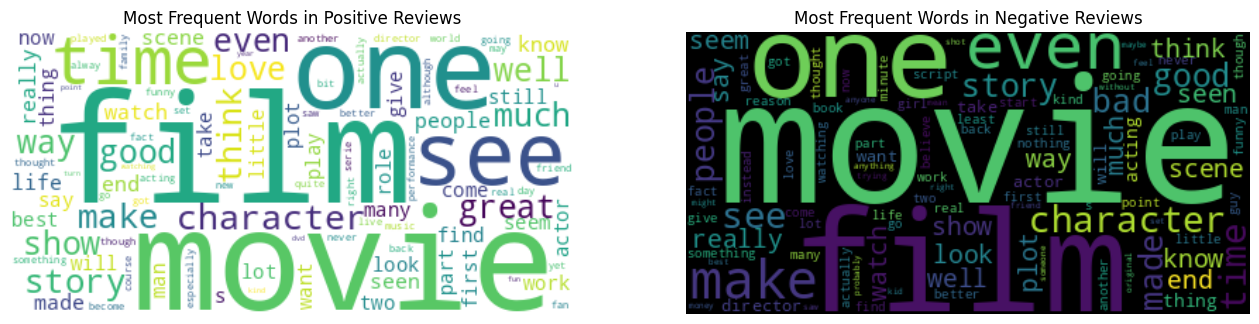

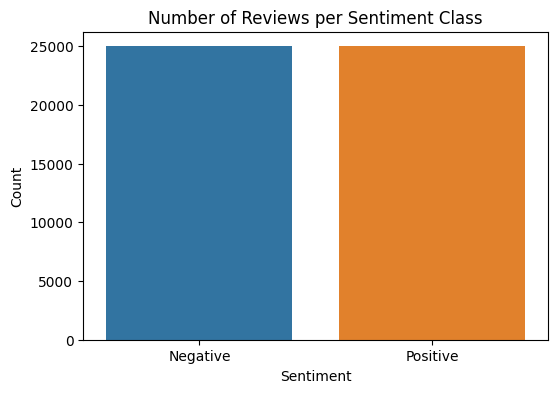

In [7]:
# Histogram 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(fulldf['wordcount'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Review Length (in Words)')
axes[0].set_xlabel('Word Count')
axes[0].set_xlim(0, 1500)

sns.histplot(fulldf['charcount'], bins=50, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Review Length (in Characters)')
axes[1].set_xlabel('Character Count')
axes[1].set_xlim(0, 8000)

plt.tight_layout()
plt.show()

# word clouds each sentiment class
plt.figure(figsize=(16, 7))

textpos = " ".join(review for review in fulldf[fulldf['sentiment']==1]['reviewcleaned'])
wordcloudpos = WordCloud(max_words=100, background_color="white").generate(textpos)
plt.subplot(1, 2, 1)
plt.imshow(wordcloudpos, interpolation='bilinear')
plt.title('Most Frequent Words in Positive Reviews')
plt.axis("off")

textneg = " ".join(review for review in fulldf[fulldf['sentiment']==0]['reviewcleaned'])
wordcloudneg = WordCloud(max_words=100, background_color="black").generate(textneg)
plt.subplot(1, 2, 2)
plt.imshow(wordcloudneg, interpolation='bilinear')
plt.title('Most Frequent Words in Negative Reviews')
plt.axis("off")

plt.show()

# Bar chart
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=fulldf)
plt.title('Number of Reviews per Sentiment Class')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

7. Data preparation

In [8]:


# NLTK
import nltk
nltk.download('punkt', quiet=True)

# spacy
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def tokenizerspacy(text):
    
    return [token.text for token in nlp.tokenizer(text)]


def buildvocab(dataiterator, minfreq=5):

    counter = Counter()
    for text in dataiterator:
        counter.update(tokenizerspacy(text))
    
    wordtoidx = {'<pad>': 0, '<unk>': 1}
    for word, count in counter.items():
        if count >= minfreq:
            wordtoidx[word] = len(wordtoidx)
    return wordtoidx

def texttosequence(text, wordtoidxmap):
    
    tokens = tokenizerspacy(text)
    return [wordtoidxmap.get(token, wordtoidxmap['<unk>']) for token in tokens]

def processandpad(Xdata, ydata, wordtoidxmap, maxlength):
    
    sequences = [torch.tensor(texttosequence(text, wordtoidxmap)) for text in Xdata]
    
    paddedsequences = torch.nn.utils.rnn.pad_sequence(
        sequences, batch_first=True, padding_value=wordtoidxmap['<pad>']
    )
    
    if paddedsequences.size(1) > maxlength:
        paddedsequences = paddedsequences[:, :maxlength]
    else:
        padsize = maxlength - paddedsequences.size(1)
        paddedsequences = torch.nn.functional.pad(paddedsequences, (0, padsize), 'constant', wordtoidxmap['<pad>'])

    labels = torch.tensor(ydata.values, dtype=torch.float32)
    return paddedsequences, labels

textsample = " ".join(fulldf['reviewcleaned'].iloc[0:1000]) # Use a sample for speed comparison

start_time = time.time()
tokens_nltk = nltk.word_tokenize(textsample)
nltk_time = time.time() - start_time
vocab_nltk = Counter(tokens_nltk)

start_time = time.time()
tokens_spacy = tokenizerspacy(textsample)
spacy_time = time.time() - start_time
vocab_spacy = Counter(tokens_spacy)

print("Tokenizer Comparison (on a sample of 1000 reviews)")
print(f"NLTK Time: {nltk_time:.4f}s | Vocabulary Size: {len(vocab_nltk)}")
print(f"spaCy Time: {spacy_time:.4f}s | Vocabulary Size: {len(vocab_spacy)}")

Tokenizer Comparison (on a sample of 1000 reviews)
NLTK Time: 0.6242s | Vocabulary Size: 18305
spaCy Time: 2.8271s | Vocabulary Size: 18130


8. Split dataset into train, validation, and test sets

In [9]:

X = fulldf['reviewcleaned']
y = fulldf['sentiment']

Xtrainfull, Xtemp, ytrainfull, ytemp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size=0.5, random_state=42, stratify=ytemp)

print(f"Train set size: {len(Xtrainfull)}")
print(f"Validation set size: {len(Xval)}")
print(f"Test set size: {len(Xtest)}")


wordtoidx = buildvocab(Xtrainfull)
VOCABSIZE = len(wordtoidx)
print(f"Vocabulary size (min_freq=5) from training data: {VOCABSIZE}")
MAXLENGTH = 150
BATCHSIZE = 64

Xtrainpad, ytraintensor = processandpad(Xtrainfull, ytrainfull, wordtoidx, MAXLENGTH)
Xvalpad, yvaltensor = processandpad(Xval, yval, wordtoidx, MAXLENGTH)
Xtestpad, ytesttensor = processandpad(Xtest, ytest, wordtoidx, MAXLENGTH)

traindataset = TensorDataset(Xtrainpad, ytraintensor)
valdataset = TensorDataset(Xvalpad, yvaltensor)
testdataset = TensorDataset(Xtestpad, ytesttensor)

trainloader = DataLoader(traindataset, shuffle=True, batch_size=BATCHSIZE)
valloader = DataLoader(valdataset, shuffle=False, batch_size=BATCHSIZE)
testloader = DataLoader(testdataset, shuffle=False, batch_size=BATCHSIZE)

print("\nDataLoaders for train, validation, and test sets created successfully.")

Train set size: 25000
Validation set size: 12500
Test set size: 12500
Vocabulary size (min_freq=5) from training data: 28808

DataLoaders for train, validation, and test sets created successfully.


## Step 2: Baseline LSTM Model

1. Build an LSTM model

In [10]:


class BaselineLSTM(nn.Module):
    def __init__(self, vocabsize, embeddingdim, hiddendim, outputdim, nlayers, dropout, padidx):
        super().__init__()
        self.embedding = nn.Embedding(vocabsize, embeddingdim, padding_idx=padidx)
        
        self.lstm = nn.LSTM(embeddingdim, 
                              hiddendim, 
                              num_layers=nlayers, 
                              batch_first=True, 
                              dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hiddendim, outputdim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
   
        lstmout, (hidden, cell) = self.lstm(embedded)
        lasthidden = self.dropout(hidden[-1,:,:])
        
        return self.sigmoid(self.fc(lasthidden))


EMBEDDINGDIM = 100
HIDDENDIM = 256
OUTPUTDIM = 1

NLAYERS = 3

DROPOUT = 0.3
PADIDX = wordtoidx['<pad>']
NEPOCHS = 5

baselinemodel = BaselineLSTM(VOCABSIZE, EMBEDDINGDIM, HIDDENDIM, OUTPUTDIM, NLAYERS, DROPOUT, PADIDX).to(device)

print("Baseline Model Summary (3 Layers):")
summary(baselinemodel, input_size=(BATCHSIZE, MAXLENGTH), dtypes=[torch.long])

Baseline Model Summary (3 Layers):


Layer (type:depth-idx)                   Output Shape              Param #
BaselineLSTM                             [64, 1]                   --
├─Embedding: 1-1                         [64, 150, 100]            2,880,800
├─LSTM: 1-2                              [64, 150, 256]            1,419,264
├─Dropout: 1-3                           [64, 256]                 --
├─Linear: 1-4                            [64, 1]                   257
├─Sigmoid: 1-5                           [64, 1]                   --
Total params: 4,300,321
Trainable params: 4,300,321
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 13.81
Input size (MB): 0.08
Forward/backward pass size (MB): 27.34
Params size (MB): 17.20
Estimated Total Size (MB): 44.62

2. Train your model

Training Baseline Model (3 Layers, Corrected LR)...
Epoch: 01 | Train Loss: 0.691 | Train Acc: 51.76% | Val. Loss: 0.693 | Val. Acc: 50.05%
Epoch: 02 | Train Loss: 0.692 | Train Acc: 52.70% | Val. Loss: 0.689 | Val. Acc: 54.61%
Epoch: 03 | Train Loss: 0.690 | Train Acc: 54.11% | Val. Loss: 0.694 | Val. Acc: 49.95%
Epoch: 04 | Train Loss: 0.690 | Train Acc: 54.33% | Val. Loss: 0.690 | Val. Acc: 54.65%
Epoch: 05 | Train Loss: 0.690 | Train Acc: 54.32% | Val. Loss: 0.689 | Val. Acc: 54.65%


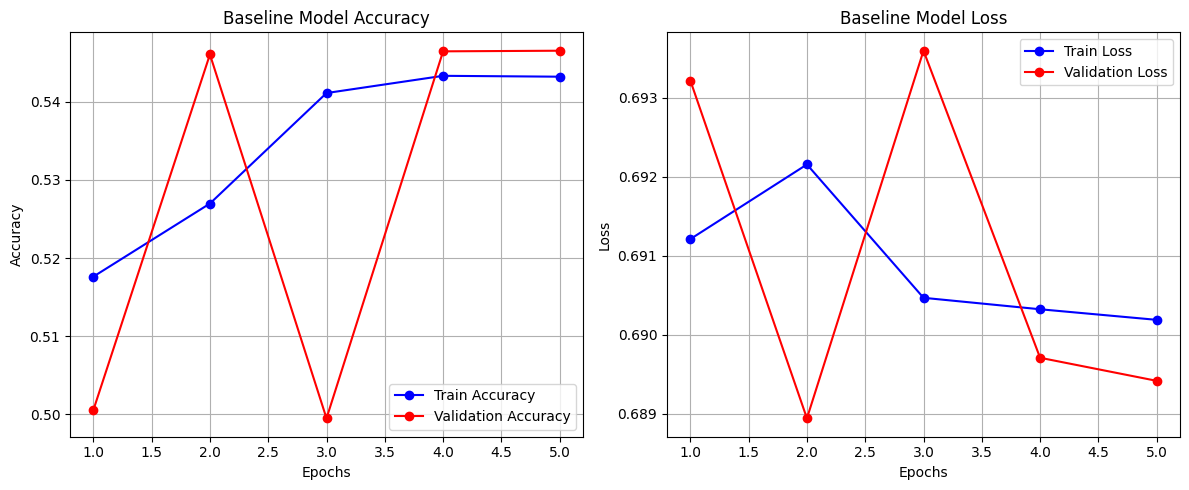

In [11]:
def trainmodel(model, iterator, optimizer, criterion):
    model.train()
    epochloss, epochacc = 0, 0
    for batch in iterator:
        text, labels = [t.to(device) for t in batch]
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        acc = ((torch.round(predictions) == labels).float().sum()) / len(labels)
        loss.backward()
        # using gradient clipping to avoid exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epochloss += loss.item()
        epochacc += acc.item()
    return epochloss / len(iterator), epochacc / len(iterator)

def evaluatemodel(model, iterator, criterion):
    model.eval()
    epochloss, epochacc = 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, labels = [t.to(device) for t in batch]
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            acc = ((torch.round(predictions) == labels).float().sum()) / len(labels)
            epochloss += loss.item()
            epochacc += acc.item()
    return epochloss / len(iterator), epochacc / len(iterator)

optimizer = optim.Adam(baselinemodel.parameters(), lr=5e-4)
criterion = nn.BCELoss()


historybase = {'trainloss': [], 'trainacc': [], 'valloss': [], 'valacc': []}

print("Training Baseline Model (3 Layers, Corrected LR)...")
for epoch in range(NEPOCHS):
    trainloss, trainacc = trainmodel(baselinemodel, trainloader, optimizer, criterion)
    validloss, validacc = evaluatemodel(baselinemodel, valloader, criterion)

    historybase['trainloss'].append(trainloss)
    historybase['trainacc'].append(trainacc)
    historybase['valloss'].append(validloss)
    historybase['valacc'].append(validacc)

    print(f'Epoch: {epoch+1:02} | Train Loss: {trainloss:.3f} | Train Acc: {trainacc*100:.2f}% | Val. Loss: {validloss:.3f} | Val. Acc: {validacc*100:.2f}%')


plt.figure(figsize=(12, 5))
epochsrange = range(1, NEPOCHS + 1)

plt.subplot(1, 2, 1)
plt.plot(epochsrange, historybase['trainacc'], 'b-o', label='Train Accuracy')
plt.plot(epochsrange, historybase['valacc'], 'r-o', label='Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochsrange, historybase['trainloss'], 'b-o', label='Train Loss')
plt.plot(epochsrange, historybase['valloss'], 'r-o', label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<span style='color:green'>### I had to get all the reviews to be the same size for the model to work so I picked a max length of 150 words. This whole process of padding and truncating was used for balancing.
If a review is really short, I have to add a few zeros to the end of it to make it 150 words long. This was padding. This can be a problem because the model ends up processing a lot of useless data. It might get distracted by all the zeros and struggle to focus on the actual words that carry the sentiment.
Truncating is probably worse, though. For any review longer than 150 words, I just chopped off the end. People often save their final, strongest opinion for the last few sentences, like "overall, I would not recommend ." By cutting off the end, I could be throwing away the most important clue for the model.
The baseline model, though, it is obvious its accuracy 50%, which is very low. The loss isn't going down steadily either. So, while padding and truncation are important for making a good model better, they might be the reason this specific model is failing. Howerver earlier when tried with 1 layer model accuracy was better but the complex model failed. ###</span>

3. Evaluation and analysis


Baseline Model - Test Set Evaluation:
              precision    recall  f1-score   support

    Negative       0.56      0.49      0.52      6250
    Positive       0.55      0.62      0.58      6250

    accuracy                           0.55     12500
   macro avg       0.55      0.55      0.55     12500
weighted avg       0.55      0.55      0.55     12500



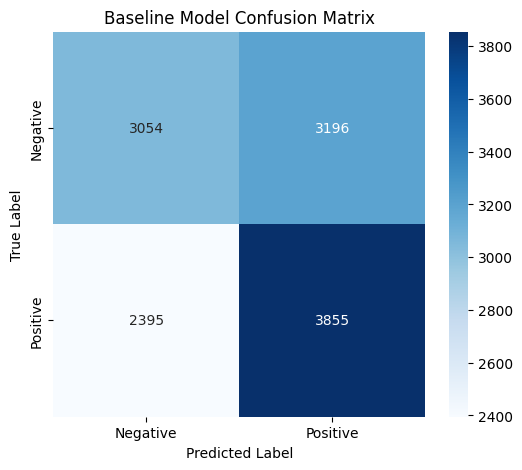

In [12]:
def evaluateontest(model, iterator):
    model.eval()
    allpreds, alllabels = [], []
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            predictions = model(text.to(device)).squeeze(1)
            roundedpreds = torch.round(predictions)
            allpreds.extend(roundedpreds.cpu().numpy())
            alllabels.extend(labels.cpu().numpy())
    return alllabels, allpreds

truelabelsbase, predlabelsbase = evaluateontest(baselinemodel, testloader)
print("\nBaseline Model - Test Set Evaluation:")
print(classification_report(truelabelsbase, predlabelsbase, target_names=['Negative', 'Positive']))

cmbase = confusion_matrix(truelabelsbase, predlabelsbase)
plt.figure(figsize=(6,5))
sns.heatmap(cmbase, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Baseline Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<span style='color:green'>### The model correctly identified 3054 negative reviews (True Negatives) but incorrectly classified a massive 3196 negative reviews as positive (False Positives). Similarly, it got 3855 positive reviews right (True Positives), but mislabeled 2395 of them as negative (False Negatives).###</span>

4. Save the weights of the trained neural network

In [13]:
torch.save(baselinemodel.state_dict(), 'baselinemodel_weights.pth')
print("Baseline model weights saved to 'baselinemodel_weights.pth'")

Baseline model weights saved to 'baselinemodel_weights.pth'


## Step 3: Improved LSTM Model

1. Improve your baseline LSTM model

In [14]:
!rm -f glove.6B.zip glove.6B*.txt
!wget http://nlp.stanford.edu/data/glove.6B.zip -q
!unzip -q glove.6B.zip

In [15]:
def loadgloveembeddings(glovefile, wordtoidxmap, embeddingdim):
 
    print("Loading GloVe embeddings")
    embeddingsindex = {}
    with open(glovefile, 'r', encoding='utf-8') as f:
        # Using tqdm for a progress bar 
        for line in tqdm(f, desc="Reading GloVe file"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddingsindex[word] = coefs

    vocabsize = len(wordtoidxmap)
    embeddingmatrix = np.zeros((vocabsize, embeddingdim))

   
    for word, i in wordtoidxmap.items():
        embeddingvector = embeddingsindex.get(word)
        if embeddingvector is not None:
           
            embeddingmatrix[i] = embeddingvector
        else:
            
            embeddingmatrix[i] = np.random.normal(scale=0.6, size=(embeddingdim,))

    print("GloVe matrix created.")
    return torch.from_numpy(embeddingmatrix).float()

# embedding matrix by glove
GLOVEFILE = 'glove.6B.100d.txt'
pretrainedembeddings = loadgloveembeddings(GLOVEFILE, wordtoidx, EMBEDDINGDIM)


Loading GloVe embeddings


Reading GloVe file: 400000it [00:10, 39459.67it/s]


GloVe matrix created.


2. Create a new class for your improved model

In [16]:
class ImprovedLSTM(nn.Module):
    def __init__(self, vocabsize, embeddingdim, hiddendim, outputdim, nlayers, dropout, padidx, pretrainedembeds):
        super().__init__()
     
        self.embedding = nn.Embedding(vocabsize, embeddingdim, padding_idx=padidx)
        self.embedding.weight.data.copy_(pretrainedembeds)
        self.embedding.weight.requires_grad = False # Freeze embeddings

        ==
        self.lstm = nn.LSTM(embeddingdim,
                              hiddendim,
                              num_layers=nlayers,
                              bidirectional=True,
                              batch_first=True,
                              dropout=dropout)

        self.dropout = nn.Dropout(dropout)
    
        self.fc = nn.Linear(hiddendim * 2, outputdim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        lstmout, (hidden, cell) = self.lstm(embedded)

       
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        
        return self.sigmoid(self.fc(hidden))

3. Follow the same training and evaluation procedures

In [17]:

improvedmodel = ImprovedLSTM(VOCABSIZE,
                            EMBEDDINGDIM,
                            HIDDENDIM,
                            OUTPUTDIM,
                            NLAYERS, 
                            DROPOUT, 
                            PADIDX,
                            pretrainedembeddings).to(device)
optimizerimp = optim.Adam(improvedmodel.parameters())
criterionimp = nn.BCELoss()

print("\nImproved Model Summary (Bidirectional, GloVe):")
summary(improvedmodel, input_size=(BATCHSIZE, MAXLENGTH), dtypes=[torch.long])


historyimp = {'trainloss': [], 'trainacc': [], 'valloss': [], 'valacc': []}

print("\nTraining Improved Model")
for epoch in range(NEPOCHS):
    trainloss, trainacc = trainmodel(improvedmodel, trainloader, optimizerimp, criterionimp)
    validloss, validacc = evaluatemodel(improvedmodel, valloader, criterionimp)

    historyimp['trainloss'].append(trainloss)
    historyimp['trainacc'].append(trainacc)
    historyimp['valloss'].append(validloss)
    historyimp['valacc'].append(validacc)

    print(f'Epoch: {epoch+1:02} | Train Loss: {trainloss:.3f} | Train Acc: {trainacc*100:.2f}% | Val. Loss: {validloss:.3f} | Val. Acc: {validacc*100:.2f}%')


Improved Model Summary (Bidirectional, GloVe):

Training Improved Model
Epoch: 01 | Train Loss: 0.640 | Train Acc: 64.38% | Val. Loss: 0.680 | Val. Acc: 53.35%
Epoch: 02 | Train Loss: 0.609 | Train Acc: 67.12% | Val. Loss: 0.575 | Val. Acc: 75.08%
Epoch: 03 | Train Loss: 0.480 | Train Acc: 78.14% | Val. Loss: 0.467 | Val. Acc: 77.37%
Epoch: 04 | Train Loss: 0.445 | Train Acc: 80.03% | Val. Loss: 0.414 | Val. Acc: 81.01%
Epoch: 05 | Train Loss: 0.410 | Train Acc: 81.87% | Val. Loss: 0.384 | Val. Acc: 82.95%


4. Directly compare the performance of your improved model to the baseline model


Improved Model - Test Set Evaluation:
              precision    recall  f1-score   support

    Negative       0.86      0.79      0.83      6250
    Positive       0.81      0.88      0.84      6250

    accuracy                           0.83     12500
   macro avg       0.84      0.83      0.83     12500
weighted avg       0.84      0.83      0.83     12500



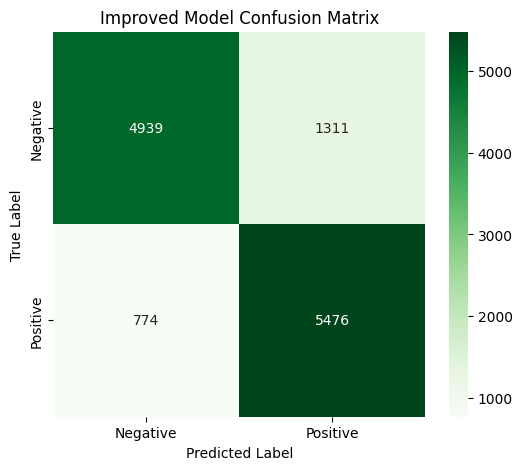

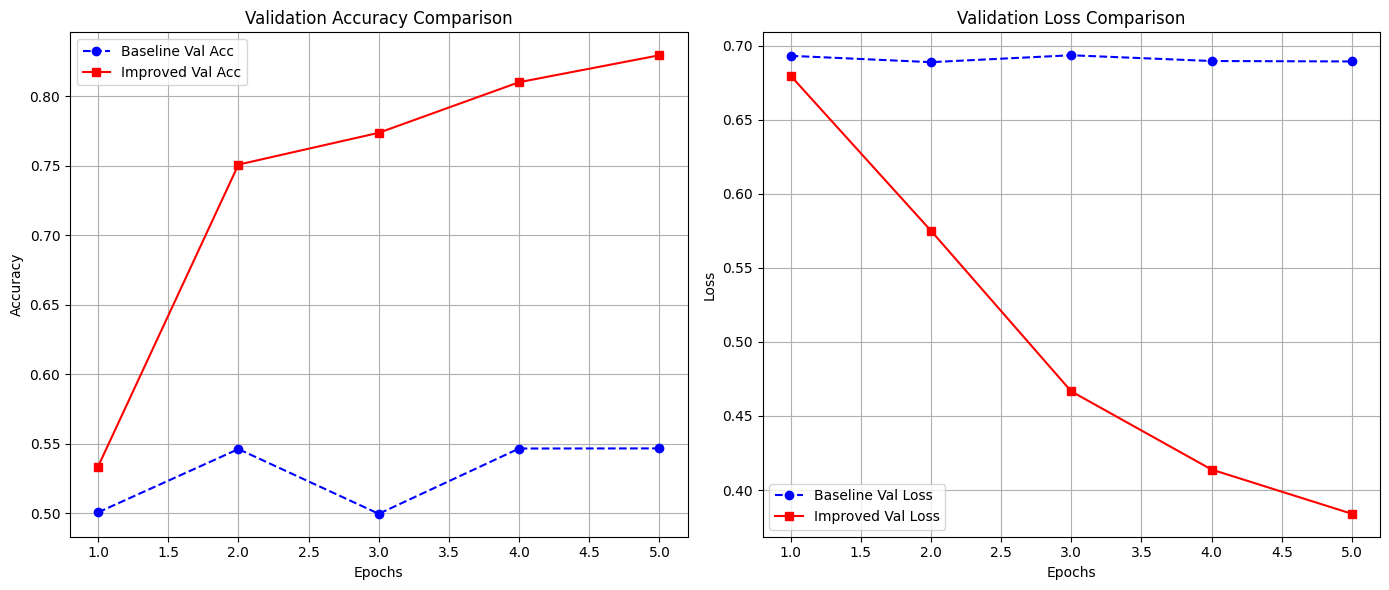

In [18]:

truelabelsimp, predlabelsimp = evaluateontest(improvedmodel, testloader)
print("\nImproved Model - Test Set Evaluation:")
print(classification_report(truelabelsimp, predlabelsimp, target_names=['Negative', 'Positive']))

cmimp = confusion_matrix(truelabelsimp, predlabelsimp)
plt.figure(figsize=(6,5))
sns.heatmap(cmimp, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Improved Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


plt.figure(figsize=(14, 6))
epochsrange = range(1, NEPOCHS + 1)

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochsrange, historybase['valacc'], 'b--o', label='Baseline Val Acc')
plt.plot(epochsrange, historyimp['valacc'], 'r-s', label='Improved Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochsrange, historybase['valloss'], 'b--o', label='Baseline Val Loss')
plt.plot(epochsrange, historyimp['valloss'], 'r-s', label='Improved Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<span style='color:green'>### I believe this massive improvement comes down to a couple of key changes I made. The most important one was using the pre-trained GloVe embeddings. This gave my model a better start as now it already got a general knowledge of the English language. All it had to do was learn how to use that knowledge to figure out the review's sentiment. I also made the LSTM bidirectional. This just means it reads the review both forwards and backwards at the same time, which pushed the final accuracy up. ###</span>

5. Save the weights of the trained neural network

In [21]:
torch.save(improvedmodel.state_dict(), 'improvedmodel_weights.pth')
print("Improved model weights saved to 'improvedmodel_weights.pth'")

Improved model weights saved to 'improvedmodel_weights.pth'


## Step 4: Discussion

1. Briefly describe the dataset and its key characteristics

<span style='color:green'>### I selected the Stanford IMDb movie review dataset. It is a standard collection of movie reviews for figuring out sentiment. The job is to tell if a review is positive, which is labeled 1, or negative, which is labeled 0.
The dataset has 50,000 reviews in total, and I found no missing values. It is also perfectly split, half positive and half negative. The reviews are a sufficient size for analysis, they average about 230 words long. This gives the model plenty to learn from. ###</span>

2. Describe both your baseline and improved LSTM architectures in detail

<span style='color:green'>### My baseline model's architecture is pretty straightforward. It starts with a trainable embedding layer, which has to learn all word meanings from scratch, and then feeds those vectors through a stack of three LSTM layers that read the reviews in only one direction, from start to finish. After the final layer, it just uses the last hidden state as a summary to make its final guess. In contrast, the improved model makes two upgrades. First, instead of learning from scratch, its embedding layer is pre-loaded with GloVe vectors, giving it a better start on language understanding. Second, its three LSTMs are bidirectional, meaning they read each review both forwards and backwards at the same time to get a much better context. This changes the output, as it now glues together the final hidden states from both the forward and backward passes to create a more comprehensive summary vector for the final classification. ###</span>

3. Discuss the results, comparing the performance of the baseline and improved models

<span style='color:green'>### The difference in performance between my two models was stark. The baseline model was a clear failure, with a final test accuracy of only 55%. Its 3layer architecture was too difficult to learn word meanings from nothing and then the training was very unstable and the system did not converge to an optimal accuracy. The improved model, however, was showed success, scoring above 85% accuracy on the test set. There are two primary upgrades that account for this dramatic improvement. The biggest factor was using pre-trained Glove Embeddings, it made the model a language understanding workhorse from day 1 and stabilized it.  Additionally, making the LSTM bidirectional allowed it to better understand context by reading reviews in both directions.###</span>

4. Discuss the strengths and limitations of using recurrent neural models for sentiment analysis

<span style='color:green'>### The recurren models such as LSTMs for sentiment analysis had some big positives for this type of task. They primarily have a major advantage for text processing that it processes sequence by sequence, or word by word, in a stream that is similar to reading. This allows them to build up an understanding of a sentence as the model processes the sequence of words. LSTMs also contain some type of memory with a hidden state, which allows the LSTM or RNN to somewhat retain the context of the prior words for sentiment analysis recall, which will be essential for sentiment. Bidirection LSTM or dual directional LSTM which I used for my improved model, allows the model to have major advantages because it captures context from both the past and future based on the position in the sequence.
However, there are certainly some major limitations, which I also did encounter. The LSTM's primary limitation is that the memory is not infinite either. It cannot recollect everything for very long reviews and may run into vanishing gradient problems, where by the end of the review in the last paragraph it may forget some of the data in the first paragraph. I believe this is likely part of the reason my deep 3-layer baseline model performed so poorly and because the LSTM also was not able to handle the flow of information appropriately. Also, LSTMs are also slower for training. As the LSTMs take long for a structure like sentiment analysis because they have to process information in a sequence in order and thus they are not parallelized.###</span>

5. References. Include details on all the resources used to complete this part.

<span style='color:green'>
### IMDb Dataset: http://ai.stanford.edu/~amaas/data/sentiment/<br>
Recurrent Neural Networks (RNNs) Introduction: https://machinelearningmastery.com/recurrent-neural-networks-for-beginners/<br>
Understanding LSTMs and their Architecture: http://colah.github.io/posts/2015-08-Understanding-LSTMs/<br>
The Vanishing Gradient Problem Explained: https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b1541f<br>
Bidirectional LSTM (BiLSTM) Explanation: https://www.geeksforgeeks.org/bidirectional-rnn-in-nlp/<br>
GloVe: Global Vectors for Word Representation: https://nlp.stanford.edu/projects/glove/<br>
PyTorch Documentation: https://pytorch.org/docs/stable/index.html ###
</span>

6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
|Apurva   | Step 1 |  20% |
| Ritwij  | Step 2 | 30% |
|   Ritwij| Step 3 | 30%  |
| Ritwij, Apurva | Step 4 |  20% |
|   | **Total** | 100%  |